In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Prepare Image Directories

In [2]:
df = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/train.csv", index_col=0)
print(df.shape)
df.head()

(1821, 4)


,healthy,multiple_diseases,rust,scab
image_id,,,,
Train_0,0,0,0,1
Train_1,0,1,0,0
Train_2,1,0,0,0
Train_3,0,0,1,0
Train_4,1,0,0,0


In [3]:
from sklearn.model_selection import train_test_split

train_set, valid_set = train_test_split(df, test_size=0.2, random_state=42)

print(train_set.shape)
print(valid_set.shape)

(1456, 4)
(365, 4)


In [4]:
import shutil
from shutil import copyfile

# delete temp dir
if os.path.exists('/kaggle/temp/'):
    shutil.rmtree('/kaggle/temp/')

os.mkdir('/kaggle/temp/')

# train directory
os.mkdir('/kaggle/temp/train')
os.mkdir('/kaggle/temp/train/healthy')
os.mkdir('/kaggle/temp/train/multiple_diseases')
os.mkdir('/kaggle/temp/train/rust')
os.mkdir('/kaggle/temp/train/scab')

# validation directory
os.mkdir('/kaggle/temp/valid')
os.mkdir('/kaggle/temp/valid/healthy')
os.mkdir('/kaggle/temp/valid/multiple_diseases')
os.mkdir('/kaggle/temp/valid/rust')
os.mkdir('/kaggle/temp/valid/scab')

In [5]:
SOURCE = '/kaggle/input/plant-pathology-2020-fgvc7/images/'

TRAIN_DIR = '/kaggle/temp/train/'

# copy images to train directory
for index, data in train_set.iterrows():
    label = df.columns[np.argmax(data)]
    filepath = os.path.join(SOURCE, index + ".jpg")
    destination = os.path.join(TRAIN_DIR, label, index + ".jpg")
    copyfile(filepath, destination)
    
for subdir in os.listdir(TRAIN_DIR):
    print(subdir, len(os.listdir(os.path.join(TRAIN_DIR, subdir))))

healthy 416
scab 465
multiple_diseases 73
rust 502


In [6]:
VALID_DIR = '/kaggle/temp/valid/'

# copy images to valid directory
for index, data in valid_set.iterrows():
    label = df.columns[np.argmax(data)]
    filepath = os.path.join(SOURCE, index + ".jpg")
    destination = os.path.join(VALID_DIR, label, index + ".jpg")
    copyfile(filepath, destination)
    
for subdir in os.listdir(VALID_DIR):
    print(subdir, len(os.listdir(os.path.join(VALID_DIR, subdir))))

healthy 100
scab 127
multiple_diseases 18
rust 120


# Epxlore Images

In [7]:
healthy_dir = os.path.join(TRAIN_DIR, 'healthy')
mdiseases_dir = os.path.join(TRAIN_DIR, 'multiple_diseases')
scab_dir = os.path.join(TRAIN_DIR, 'scab')
rust_dir = os.path.join(TRAIN_DIR, 'rust')

healthy_files = os.listdir(healthy_dir)
mdiseases_files = os.listdir(mdiseases_dir)
scab_files = os.listdir(scab_dir)
rust_files = os.listdir(rust_dir) 

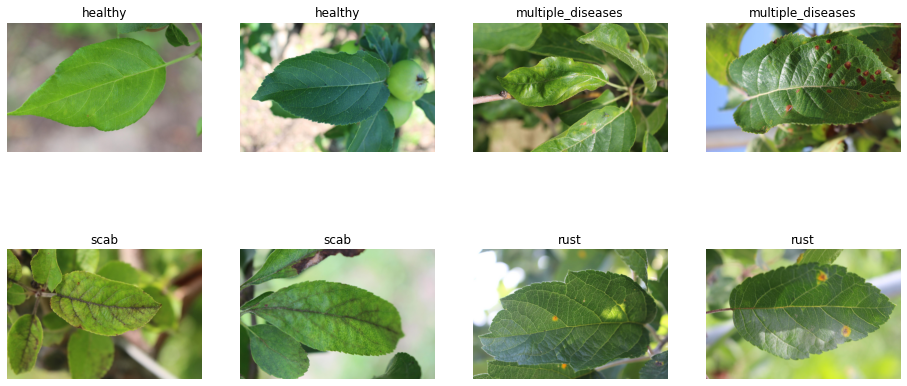

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_healthy = [os.path.join(healthy_dir, fname) for fname in healthy_files[pic_index-2:pic_index]]
next_mdiseases = [os.path.join(mdiseases_dir, fname) for fname in mdiseases_files[pic_index-2:pic_index]]
next_scab = [os.path.join(scab_dir, fname) for fname in scab_files[pic_index-2:pic_index]]
next_rust = [os.path.join(rust_dir, fname) for fname in rust_files[pic_index-2:pic_index]]


nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for i, img_path in enumerate(next_healthy+next_mdiseases+next_scab+next_rust):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.title(img_path.split('/')[-2])
    plt.imshow(img)
    
plt.show()

# keras ImageGenerator API

In [9]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(rescale = 1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(TRAIN_DIR, target_size=(150,150), class_mode='categorical', batch_size=32)
validation_generator = validation_datagen.flow_from_directory(VALID_DIR, target_size=(150,150), class_mode='categorical', batch_size=32)

Found 1456 images belonging to 4 classes.
Found 365 images belonging to 4 classes.


# CNN modeling

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

2021-10-31 06:55:08.453747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-31 06:55:08.546738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-31 06:55:08.547738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

2021-10-31 06:55:08.550750: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-31 06:55:08.551784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-31 06:55:08.552759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-31 06:55:08.553700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [11]:
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("cnn.h5", save_best_only=True)

history = model.fit(train_generator, epochs=50, steps_per_epoch=46, 
                    validation_data = validation_generator, validation_steps=12, callbacks=[early_stopping_cb, checkpoint_cb])

2021-10-31 06:55:12.154293: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-10-31 06:55:14.759318: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


46/46 [==============================] - 68s 1s/step - loss: 1.3629 - accuracy: 0.3104 - val_loss: 1.2466 - val_accuracy: 0.3288
Epoch 2/50
46/46 [==============================] - 61s 1s/step - loss: 1.2598 - accuracy: 0.3221 - val_loss: 1.2885 - val_accuracy: 0.3288
Epoch 3/50
46/46 [==============================] - 61s 1s/step - loss: 1.2577 - accuracy: 0.3400 - val_loss: 1.4203 - val_accuracy: 0.3288
Epoch 4/50
46/46 [==============================] - 61s 1s/step - loss: 1.2557 - accuracy: 0.3310 - val_loss: 1.2234 - val_accuracy: 0.3315
Epoch 5/50
46/46 [==============================] - 61s 1s/step - loss: 1.2605 - accuracy: 0.3668 - val_loss: 1.2010 - val_accuracy: 0.3370
Epoch 6/50
46/46 [==============================] - 61s 1s/step - loss: 1.2370 - accuracy: 0.4066 - val_loss: 1.1903 - val_accuracy: 0.4192
Epoch 7/50
46/46 [==============================] - 61s 1s/step - loss: 1.1695 - accuracy: 0.4609 - val_loss: 1.0784 - val_accuracy: 0.5644
Epoch 8/50
46/46 [=============

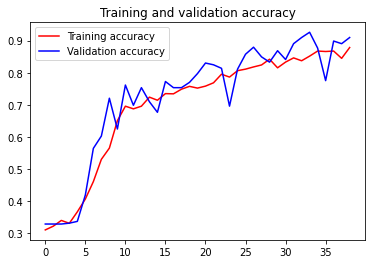

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

# Make Predictions

In [13]:
model = tf.keras.models.load_model("cnn.h5") # rollback to best model
model.evaluate(validation_generator)

12/12 [==============================] - 13s 1s/step - loss: 0.2432 - accuracy: 0.9260


[0.24316799640655518, 0.9260274171829224]

In [14]:
from keras_preprocessing import image

test_set = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/test.csv", index_col=0)

X_test = []
for index, data in test_set.iterrows():
    filepath = os.path.join(SOURCE, index + ".jpg")
    img = image.load_img(filepath, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    X_test.append(x)
    
X_test = np.vstack(X_test) / 255 # rescale images

In [15]:
y_pred = model.predict(X_test, batch_size=10)
df_out = pd.concat([test_set.reset_index(), pd.DataFrame(y_pred, columns = train_generator.class_indices.keys())], axis=1).set_index("image_id")
df_out.to_csv('submission.csv')
df_out.head()

,healthy,multiple_diseases,rust,scab
image_id,,,,
Test_0,1.481208e-11,0.015594,0.984406,6.363730e-10
Test_1,1.457169e-06,0.100413,0.899584,2.160062e-06
Test_2,5.137454e-02,0.026359,0.001693,9.205729e-01
Test_3,8.165941e-01,0.017553,0.004740,1.611134e-01
Test_4,1.171801e-13,0.006011,0.993989,6.903396e-13


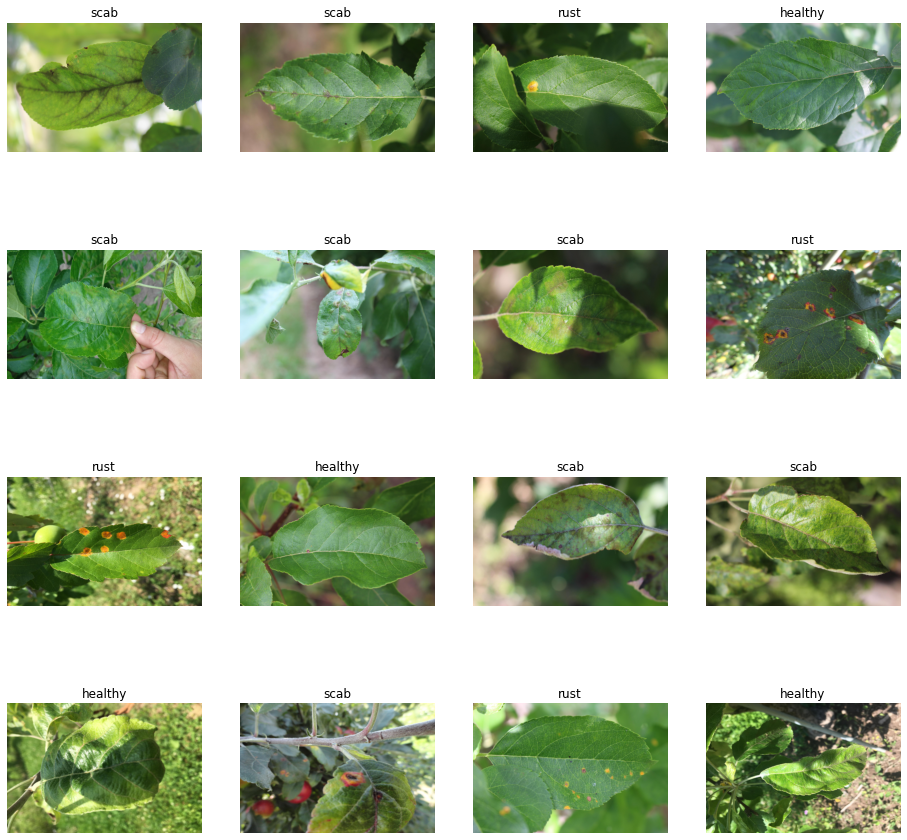

In [16]:
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for i, (idx, row) in enumerate(df_out.sample(nrows*ncols).iterrows()):
    filepath = filepath = os.path.join(SOURCE, idx + ".jpg")
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(filepath)
    plt.title(df_out.columns[np.argmax(row)])
    plt.imshow(img)
    
plt.show()